# Installation


In [0]:
!pip uninstall fastai
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

%matplotlib inline
from fastai.imports import *

# ULMFiT Emotion Detection (Hindi)

In [0]:
from fastai.text import *
import html

In [0]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('') # path to the data 

In [0]:
CLAS_PATH=Path('emotion_hindi_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('emotion_hindi_lm/')
LM_PATH.mkdir(exist_ok=True)

In [0]:
CLASSES = ['angry','sad','excited','happy','neutral']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [0]:
len(trn_texts),len(val_texts)

(315, 45)

# Data Pre-processing

In [0]:
col_names = ['labels','text']

In [0]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [0]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [0]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [0]:
df_trn.to_csv(CLAS_PATH/'train_hindi.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test_hindi.csv', header=False, index=False)

(CLAS_PATH/'classes_hindi.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

In [0]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [0]:
len(trn_texts), len(val_texts)

(324, 36)

In [0]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train_hindi.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test_hindi.csv', header=False, index=False)

# Language Model 

In [0]:
chunksize=10000

In [0]:
re1 = re.compile(r'  +')
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [0]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [0]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [0]:
df_trn = pd.read_csv(LM_PATH/'train_hindi.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test_hindi.csv', header=None, chunksize=chunksize)

In [0]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [0]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [0]:
np.save(LM_PATH/'tmp'/'tok_trn_hindi.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val_hindi.npy', tok_val)

In [0]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn_hindi.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val_hindi.npy')

In [0]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('\n', 324),
 ('xbos', 324),
 ('xfld', 324),
 ('1', 324),
 ('है', 80),
 ('हो', 49),
 ('!', 48),
 ('क्या', 45),
 ('नहीं', 43),
 ('कर', 29),
 ('एक', 29),
 ('तुम', 27),
 ('कैब', 27),
 ('का', 26),
 ('होटल', 25),
 ('बहुत', 25),
 ('था', 24),
 ('बुक', 23),
 ('?', 22),
 ('की', 22),
 ('ये', 21),
 ('काम', 21),
 ('से', 21),
 ('में', 17),
 ('एप', 16)]

In [0]:
max_vocab = 60000
min_freq = 2

In [0]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [0]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

229

In [0]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [0]:
np.save(LM_PATH/'tmp'/'trn_ids_hindi.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids_hindi.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos_hindi.pkl', 'wb'))

In [0]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids_hindi.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids_hindi.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos_hindi.pkl', 'rb'))

In [0]:
vs=len(itos)
vs,len(trn_lm)

(229, 324)

# Loading Pre-trained Language Model 

In [0]:
em_sz,nh,nl = 400,1150,3

In [0]:
PRE_PATH = PATH/'models'
PRE_LM_PATH = PRE_PATH/'wiki_hindi.h5'

In [0]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [0]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [0]:
itos2 = pickle.load((PRE_PATH/'itos_wiki_hindi.pkl').open('rb'))
itos2
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [0]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [0]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Fine-Tuning the Language Model

In [0]:
wd=1e-7
bptt=70
bs=64
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [0]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1,vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [0]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [0]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)


In [0]:
learner.model.load_state_dict(wgts)

In [0]:
lr=1e-3
lrs = lr

In [0]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      4.527924   4.103669   0.3125    



[array([4.10367]), 0.31250000141915824]

In [0]:
learner.save('lm_last_ft')

In [0]:
learner.load('lm_last_ft')

In [0]:
learner.unfreeze()

In [0]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                 
    0      3.480083   3.226838   0.422619  



In [0]:
learner.sched.plot()

In [0]:
learner.save('lm_last_ft')

In [0]:
learner.load('lm_last_ft')

In [0]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=7)

epoch      trn_loss   val_loss   accuracy                 
    0      2.850124   2.203006   0.511905  
    1      2.30186    2.079895   0.529762                 
    2      1.901223   2.056735   0.547619                 
    3      1.594627   2.050367   0.553571                 
    4      1.392824   2.057877   0.544643                 
    5      1.236012   2.121903   0.53869                  
    6      1.116298   2.11846    0.53869                  



[array([2.11846]), 0.5386904705138433]

In [0]:
learner.save('lm_fine_tuned')

In [0]:
learner.save_encoder('lm_enc_fine_tuned')

# Classifier 

In [0]:
df_trn = pd.read_csv(CLAS_PATH/'train_hindi.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test_hindi.csv', header=None, chunksize=chunksize)

In [0]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [0]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn_hindi.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val_hindi.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels_hindi.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels_hindi.npy', val_labels)

In [0]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn_hindi.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val_hindi.npy')

In [0]:
itos = pickle.load((LM_PATH/'tmp'/'itos_hindi.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

229

In [0]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [0]:
np.save(CLAS_PATH/'tmp'/'trn_ids_hindi.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids_hindi.npy', val_clas)

In [0]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids_hindi.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids_hindi.npy')

In [0]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels_hindi.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels_hindi.npy'))

In [0]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 64

In [0]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [0]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [0]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [0]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [0]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3], bidir = True)

In [0]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [0]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]


In [0]:
lr=5e-2
lrm = 2.6
#lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [0]:
wd = 0
learn.load_encoder('lm_enc_fine_tuned')

In [0]:
learn.freeze_to(-1)

 82%|████████▎ | 33/40 [00:00<00:00, 73.90it/s, loss=8.03]


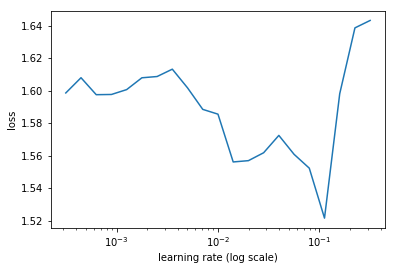

In [0]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                 
    0      1.258166   0.896462   0.64994   



[array([0.89646]), 0.6499399095773697]

In [0]:
learn.freeze_to(-2)

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                 
    0      1.119209   0.646768   0.734976  



[array([0.64677]), 0.7349759638309479]

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                  
    0      0.474603   0.418879   0.875     
    1      0.524166   0.610416   0.770132                  
    2      0.511917   0.546899   0.817007                  
    3      0.514244   0.379415   0.855769                  
    4      0.461066   0.485738   0.836538                  
    5      0.372279   0.53223    0.836538                  
    6      0.400031   0.518662   0.82512                   
    7      0.375627   0.408376   0.902644                  
    8      0.345622   0.511143   0.836839                  
    9      0.304919   0.48627    0.864183                  



[array([0.48627]), 0.8641826957464218]

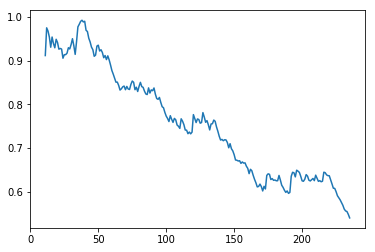

In [0]:
learn.sched.plot_loss()

In [0]:
learn.save('hindi_emotion_classifier')